# Advanced Lane Finding Project

To acomplish the project objective, I used the following 8 spteps.

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

%matplotlib inline

### Dataset Explaration

Randomly select a jpg image to be displayed from the nominated folter

Display image name: ./camera_cal/calibration5.jpg
Image Shape: (720, 1280, 3)


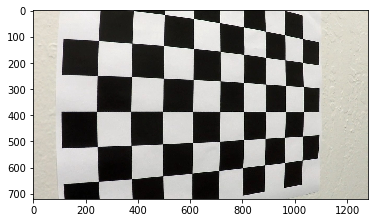

In [2]:
from random import randrange
import os

#print('pwd: {}'.format(os.getcwd()))

# Calibration images folder
CALIBRATION_DIR = './camera_cal/'   
SAV_OUTPUT_DIR = './output_images/'

# Get the number of images files in the folder
num_files = len([name for name in os.listdir(CALIBRATION_DIR) 
                 if os.path.isfile(os.path.join(CALIBRATION_DIR, name))])

# Randomly select a file from the images in the directory
afile_num = randrange(0, num_files)

# Set path to the image
img_file = 'calibration' + str(afile_num) + '.jpg'
selected_img = CALIBRATION_DIR + img_file

# Print information about image and display it 
print('Display image name: {}'.format(selected_img))
img = mpimg.imread(selected_img)

# Get the image shape
image_shape = img.shape

print("Image Shape: {}".format(image_shape))
plt.imshow(img)


## Camera Calibration

From the image it can be assert that the number of internal corners in the chessboard is a 9 Columns by 6 Rows.

(-0.5, 1279.5, 719.5, -0.5)

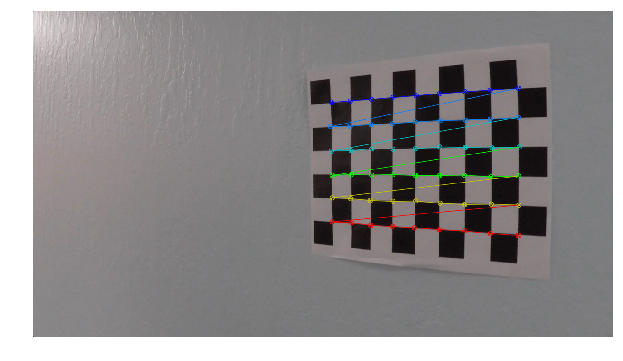

In [3]:
num_x = 9
num_y = 6

# Points to map to in the undistorted image
objpoints = []

# Points on the disturted image to be map
imgpoints = []

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((num_x * num_y, 3), np.float32)
objp[:,:2] = np.mgrid[0:num_x, 0:num_y].T.reshape(-1,2)

files_str = CALIBRATION_DIR +'calibration*.jpg'
fnames = glob.glob(files_str)

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (num_x, num_y), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        
# Caliberating the camera and computing it matrix and distortion coefficients
ret, camMatrix, distorCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                                 imgpoints, 
                                                                 image_shape[:2],
                                                                 None,
                                                                 None)
                
# Lets print one example of the found corners
img = cv2.imread("camera_cal/calibration12.jpg")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
cv2.drawChessboardCorners(img, (9, 6), corners, ret)

plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis("off")

### Helping Funtions

In [4]:
def display_2_img(img_1, img_1_title, img_2, img_2_title):
    """
    Display the two given images with there respective titles side by side
    
    """
    fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(30, 15))
    
    # Set ax_1 to as orig_img
    ax_1.imshow(img_1)
    ax_1.set_title(img_1_title, fontsize=50)

    # Set ax_2 to as new_img
    ax_2.imshow(img_2)
    ax_2.set_title(img_2_title, fontsize=50)

    fig.tight_layout()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

    
def get_warp_img(img, src, dst):
    """
    Apply perspective transformation on the provided image to gain a birds-eye-view,
    based on the source and destination image points.
    
    :param img: Image to transform
    :param src: Source coordinates
    :paramdst: Destination coordinates   
    :returns: A tuple with the warped image, transform matrix and inverse transform matrix
    """
    # Create a tuple (width, height)
    img_size = (img.shape[1], img.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    M_inv = cv2.getPerspectiveTransform(dst, src)

    return warped, M, M_inv


### Displaying Disturbed and Undisturbed Comparative Images 

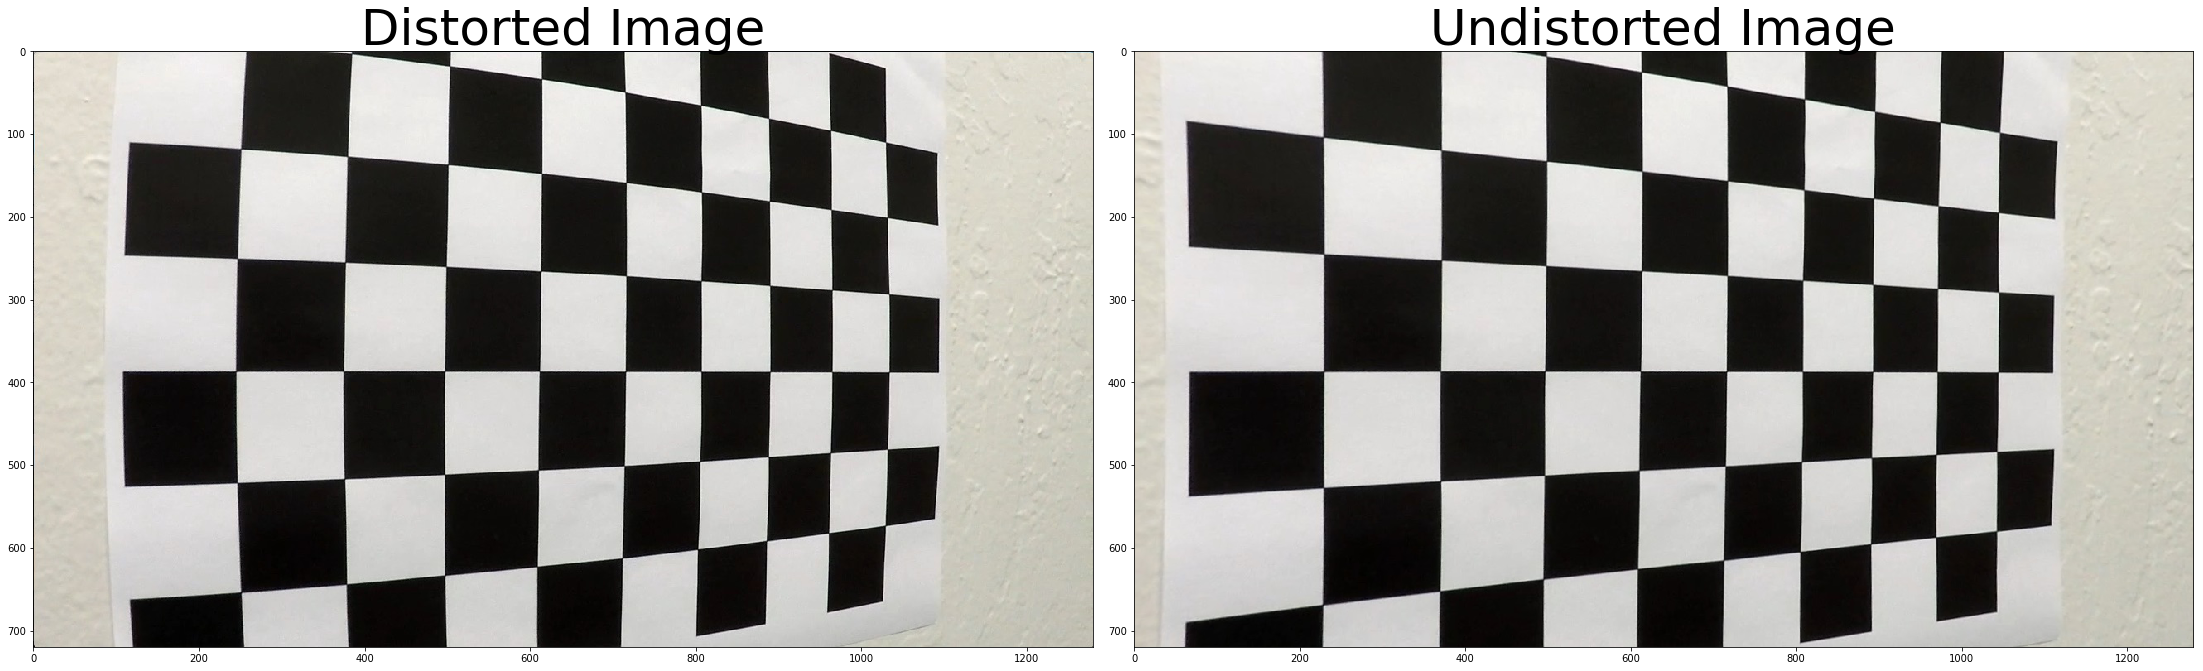

In [5]:
# Get again the original image display above
img = mpimg.imread(selected_img)

# Undistor the image
undistorted = cv2.undistort(img, camMatrix, distorCoeffs, None, camMatrix)

# Display image comparation
display_2_img(img, 'Distorted Image', undistorted, 'Undistorted Image')


## Gradients and color transforms
---

We use **Gradients Transformation** along the X axis to emphasize lane lines.  To retain only the desire lines in the image, the program use thresholds of 30 and 90 degrees.  These thresholds will filter out lines not in the driving direction.

For the **Color Transformation**, the R & G channels are used.   The S channel is used in the program to separate out white & yellow lanes, while the L channel to mitigate the effect cause by shadows.  The results from these two channels are then combined.



In [6]:
def abs_sobel_threshol(img, orient='x', thresh_min=0, thresh_max=255):
    """
    Perform a Sobel absolute value operation on an image given the gradient 
    orientation (x or Y), and the min and max threshold values.
    
    :param img: input image in RGB 
    :param orient: orientation of the gradient operation (Default: x) 
    :param thresh_min: minimum threshold (Default: 0)
    :param thresh_max: maximum threshold (Default: 255)
    :Return: a binary image with sketches lines
    """
    # Check and convert to grayscale if needed
    if len(img.shape) is 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient is 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient is 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the binary image
    return binary_output


def direction_gradient(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Find the direction gradient of the lane lines
    
     img:
    :param sobel_kernel: (Default: 3)
    :param
    Return: a binary image with line mainly in the vertical direction.
    """
    # Check and convert to grayscale if needed
    if len(img.shape) is 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def get_threshold_img(img):
    """
    Apply Distortion Correction, Gradient and Color tranfomation to the image.
    
    :param img: input image in RGB
    :Return: an image showing maily vertical lines 
    """
    img = cv2.undistort(img, camMatrix, distorCoeffs, None, camMatrix)
    
    # Convert to grayscale
    if len(img.shape) is 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    # Image dimentions
    height, width = gray.shape
    
    # apply gradient threshold on the horizontal gradient
    sx_binary = abs_sobel_threshol(gray, 'x', 10, 200)
    
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = direction_gradient(gray, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    combined_img = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # Combine all the transforamtions.  To be included, the pixel in question should
    # be either a yellow or white color type and have a gradient within the thresholds.
    combined_img[(r_g_condition & l_condition) 
                 & (s_condition | combined_condition)] = 1
    
    # Selecting only the region of interest
    region_grid = np.zeros_like(combined_img)
    region_of_interest_vertices = np.array([[0,height-1], 
                                            [width / 2, int(0.58 * height)], 
                                            [width - 1, height - 1]], dtype=np.int32)
    cv2.fillPoly(region_grid, [region_of_interest_vertices], 1)
    transforemed_img = cv2.bitwise_and(combined_img, region_grid)
    
    return transforemed_img
    
    
def get_src_dest_points(image):
    """
    Find the Source and Destination perspective transformation points.
    
    :param image: RGB image
    :return: Tuple with Source and Destination image points.
    """
    # Manualy estimated vertices for performing the perspective transform
    bottom_left = [205,height]
    bottom_right = [1100, height]
    top_left = [595, 450]
    top_right = [685, 450]
    src = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    # Destination points are chosen such that straight lanes appear more or less 
    # parallel in the transformed image.
    bottom_left = [320,height]
    bottom_right = [920, height]
    top_left = [320, 1]
    top_right = [920, 1]
    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    return src, dst

## Example of processed images

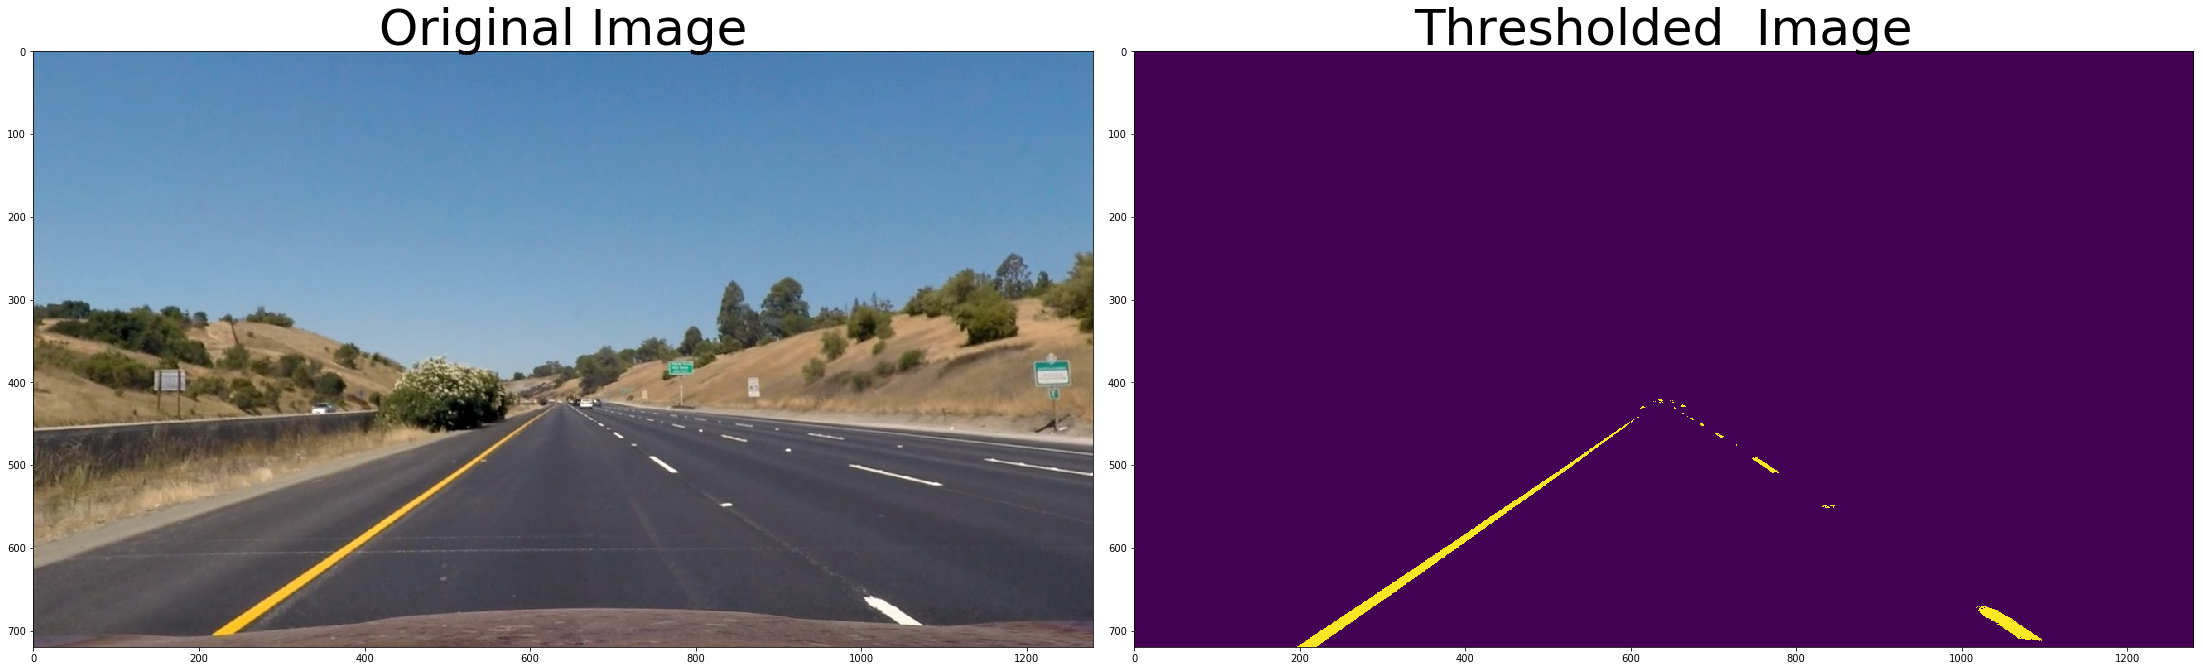

In [7]:
# Calibration images folder
TEST_IMG_DIR = './test_images/'   
TESTING_IMG = TEST_IMG_DIR + 'straight_lines1.jpg'

img = mpimg.imread(TESTING_IMG)
img = cv2.undistort(img, camMatrix, distorCoeffs, None, camMatrix)

thresholded = get_threshold_img(img)

# Display the 2 images side by side
display_2_img(img, 'Original Image', thresholded, 'Thresholded  Image')


## Perspective Transform
To perform the perspective transformation, a polygon vertices were taken from the sample image shown above was us. The transformation destination points are chosen parallel to the lanes.

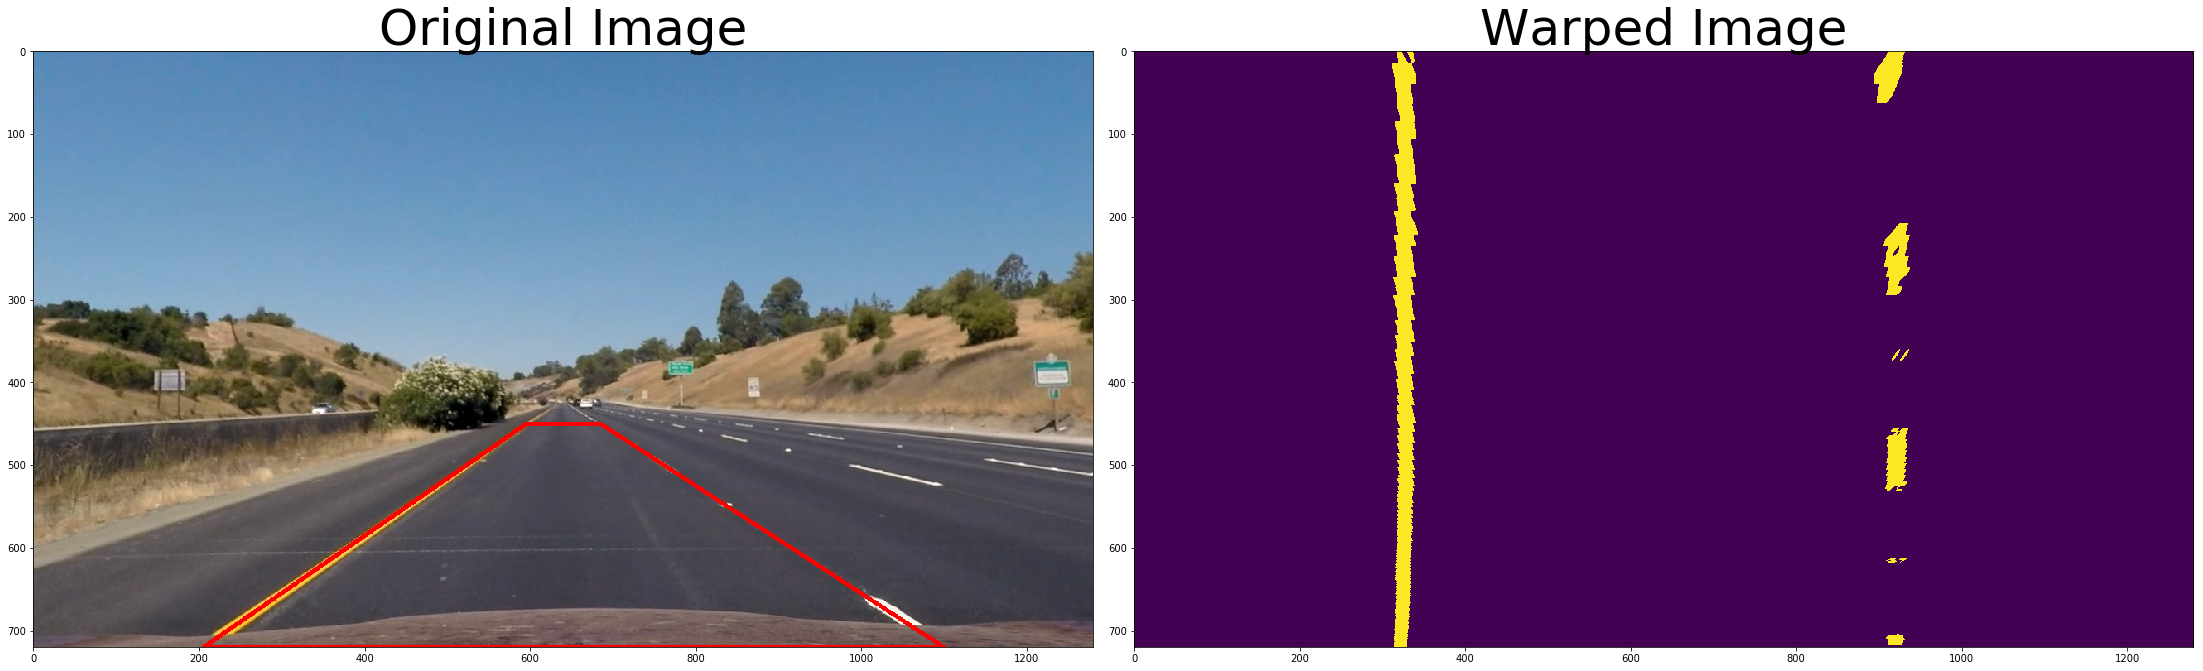

In [8]:
# Image dimentions
height, width, _ = img.shape

source, dst = get_src_dest_points(img)

# Estimated vertices for performing the perspective transform
bottom_left = [205,height]
bottom_right = [1100, height]
top_left = [595, 450]
top_right = [685, 450]

##source = np.float32([bottom_left,bottom_right,top_right,top_left])

pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
img_copy = img.copy()
cv2.polylines(img_copy,[pts],True,(255,0,0), thickness=3)


M = cv2.getPerspectiveTransform(source, dst)
M_inv = cv2.getPerspectiveTransform(dst, source)
img_size = (image_shape[1], image_shape[0])

warp_img = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)

# Display the 2 images side by side
display_2_img(img_copy, 'Original Image', warp_img, 'Warped Image')

----
## Identifying the Lane Line pixels



### - Histogram and lines origin

Creating a Histogram to select the lane lines vertical starting coordinates at the bottom  of the image.

In [9]:
def get_histogram(warp_img):
    """
    Create a histogram to find the left and right lane lines.
    
    :param warp_img: Perspective transformed image (warp).
    :return: histogram:  histogram data
             left_x_base: x values for plot of left lane
             right_x_base: x values for plot of right lane    
    """
    histogram = np.sum(warp_img[int(warp_img.shape[0]/2):, :], axis=0)

    # Divide the histogram into left and rigth
    half_width = np.int(histogram.shape[0]/2)

    # Find the left lane
    left_x_base = np.argmax(histogram[:half_width])

    # Find the right lane
    right_x_base = np.argmax(histogram[half_width:]) + half_width
    
    return histogram, left_x_base, right_x_base

Lane lines Coordinates
Bottom Left :321 - Bottom Right: 921


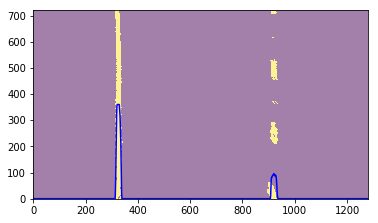

In [10]:
# Get the histogram values from the function
histogram, left_x_base, right_x_base = get_histogram(warp_img)

# Print the histogram intersection coordinates 
print('Lane lines Coordinates')
print('Bottom Left :{} - Bottom Right: {}'.format(left_x_base, right_x_base))

# Plot histogram
#plt.plot(histogram)

# Plot histogram with inverted image as background
fig, ax = plt.subplots()
ax.imshow(warp_img, alpha=.5)
ax.plot(histogram, 'b')
plt.gca().invert_yaxis()


### - Sliding Window Search and Fit Polynomial

For the sliding window search, we start at the likely base positions for the 2 lanes found using the histogram caluculation. The x & y coordinates of non zeros pixels in the images are found, these pixel correspond to the lane lines, then a polynomial is fit for these coordinates and the lane lines are drawn.

In [11]:
def second_degre_poly(poly_array, data_points):
    """
        Evaluate a second degree polynomial given an array and a data point

        :param poly_array: second order degree polynomial constants from return by np.polyfit
        :param data_points: 
        :return: An array float
    """
    
    return poly_array[0] * data_points**2 + poly_array[1] * data_points + poly_array[2]


def find_lane_lines(warp_img, margin=70, windows_frames=False, line_windows=False):
    """
    Find left and right lane lines in the given binary warped image. Start the lines
    using a histogram to find the lanes line in the bottom half of the image and then
    using a sliding window techniqe to iteratively move up and finf the next part of 
    the lane lines.
    Returns the points arrays to draw each of the left and right lanes as a 2nd order
    polynonial as well as the polynomial coefficients.
    
    :param warp_img: Binary image that has already been warped (perspective transformed).
    :param margin: Sliding windows size in pixels.   
    :param windows_frames: Display the sliding windows on the output image.
    :param line_windows: Display the frame windows onto the lane lines.
    
    :returns:
             left_fitx: x values for plot of left lane
             right_fitx: x values for plot of right lane
             ploty:  y values for plots of left and right lanes
             left_fit: 2nd order polynomial coefficients from np.polyfit for left lane
             right_fit: 2nd order polynomial coefficients from np.polyfit for right lane
    """

    # Creating an output image to draw on and  visualize the result
    out_img = np.dstack((warp_img, warp_img, warp_img)) * 255

    # Identify the x and y positions of all nonzero pixels in the image
    non_zeros = warp_img.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]

    # Set minimum number of pixels found to recenter window
    min_pixels = 200

    # Get the number of rows in the image to be used as base 
    # in the sliding windows search
    num_rows = warp_img.shape[0]

    # Number of sliding windows
    num_windows = 10

    # Set height of windows
    window_height = np.int(num_rows / num_windows)

    # Set the width of the windows +/- margin
    margin = margin
    
    # Get the left and right X bootom coordinate from the histogram
    _, left_x_base, right_x_base = get_histogram(warp_img)

    # Create empty lists to receive left and right lane pixel indices
    left_coordinates = []
    right_coordinates = []

    # Step through the windows one by one
    for window in range(num_windows):
        # Identify window boundaries in x and y (and right and left)
        y_min = num_rows - window_height * (window + 1)
        y_max = num_rows - window_height * window

        left_x_min  = left_x_base  - margin 
        left_x_max  = left_x_base  + margin  
        right_x_min = right_x_base - margin 
        right_x_max = right_x_base + margin 

        if windows_frames is True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (left_x_min, y_min), 
                      (left_x_max, y_max), [0,0,255],2)
            cv2.rectangle(out_img, (right_x_min, y_min), 
                      (right_x_max, y_max), [0,0,255],2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((non_zeros_x >= left_x_min) 
                          & (non_zeros_x <= left_x_max) 
                          & (non_zeros_y >= y_min) 
                          & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_inds)

        good_right_inds = ((non_zeros_x >= right_x_min) 
                           & (non_zeros_x <= right_x_max) 
                           & (non_zeros_y >= y_min) 
                           & (non_zeros_y <= y_max)).nonzero()[0] 
        right_coordinates.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > min_pixels:
            left_x_base = np.int(np.mean(non_zeros_x[good_left_inds])) 

        if len(good_right_inds) > min_pixels:
            right_x_base = np.int(np.mean(non_zeros_x[good_right_inds]))

    # Concatenate the arrays of indices        
    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)

    # Extract left and right line pixel positions
    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]

    # Fit a second order polynomial to each
    polyfit_left = np.polyfit(left_y, left_x, 2)
    polyfit_right = np.polyfit(right_y, right_x, 2)
    
    y_points = np.linspace(0, num_rows-1, num_rows)
    left_x_fit = second_degre_poly(polyfit_left, y_points)
    right_x_fit = second_degre_poly(polyfit_right, y_points)
     
    # Return different values depending on the flag condition
    if windows_frames is True or line_windows is True:
        out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
        out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]
        
        if line_windows is True:
            window_img = np.zeros_like(out_img)
            
            # Left line windows 
            left_line_window_1 = np.array(np.transpose(np.vstack([left_x_fit - margin, y_points])))
            left_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([left_x_fit + margin, y_points]))))
            
            # Right line windows
            right_line_window_1 = np.array(np.transpose(np.vstack([right_x_fit - margin, y_points])))
            right_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([right_x_fit + margin, y_points]))))

            # Staking left and right windows arrray
            left_line_points = np.vstack((left_line_window_1, left_line_window_2))                        
            right_line_points = np.vstack((right_line_window_1, right_line_window_2))
            
            # Fitting wrap line lane windows
            cv2.fillPoly(window_img, np.int_([left_line_points]), [0,255, 0])
            cv2.fillPoly(window_img, np.int_([right_line_points]), [0,255, 0])
            
            # Blend images into the output image
            out_img = cv2.addWeighted(out_img, 0.7, window_img, 0.3, 0)            
        return left_x_fit, right_x_fit, y_points, polyfit_left, polyfit_right, out_img
                   
    else:
        return left_x_fit, right_x_fit, y_points, polyfit_left, polyfit_right, out_img
   

### - Visualization of the Sliding Windows - Straight Lines

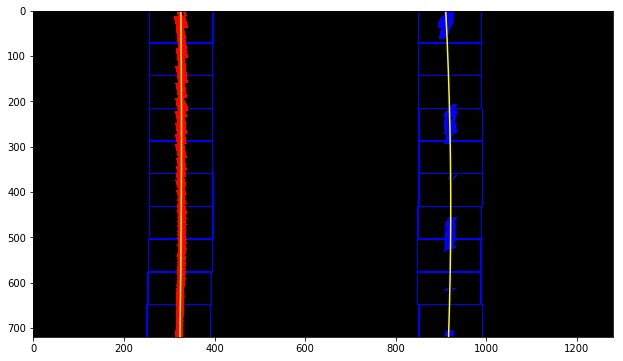

In [12]:
left_x_fit, right_x_fit, y_points, _, _, out_img = find_lane_lines(warp_img, windows_frames=True)

# Visualization
plt.figure(figsize=(12,6))
plt.imshow(out_img)
plt.plot(left_x_fit, y_points, color='yellow')
plt.plot(right_x_fit, y_points, color='yellow')


### - Visualization of the Lane Lines Pixels - Straight Lines

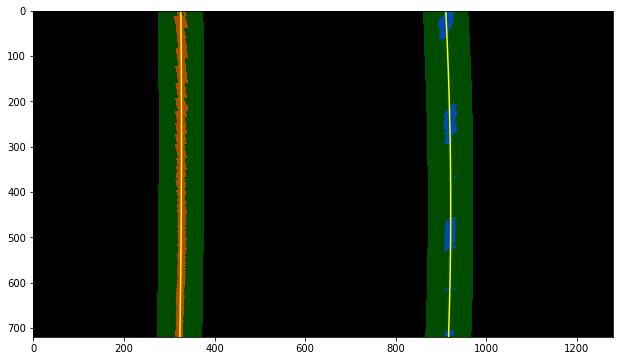

In [13]:
left_x_fit, right_x_fit, y_points, _, _, out_img = find_lane_lines(warp_img, 
                                                                   margin=50, 
                                                                   line_windows=True)

plt.figure(figsize=(12,6))
plt.imshow(out_img)
plt.plot(left_x_fit, y_points, color='yellow')
plt.plot(right_x_fit, y_points, color='yellow')

### - Visualization of the Sliding Windows - Curve Lines

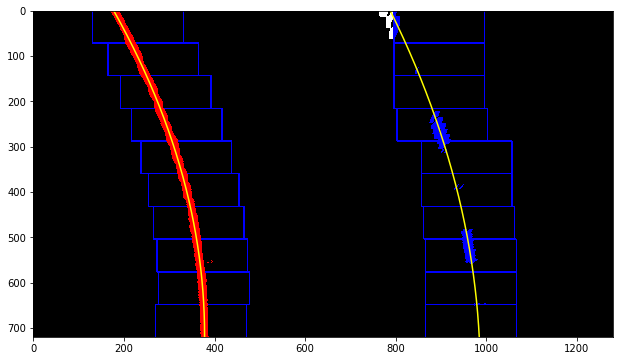

In [14]:
TESTING_IMG = TEST_IMG_DIR + 'test2.jpg'


curve_img = mpimg.imread(TESTING_IMG)
curve_img = cv2.undistort(curve_img, camMatrix, distorCoeffs, None, camMatrix)

img_size = (curve_img.shape[1], curve_img.shape[0])
curve_thresholded = get_threshold_img(curve_img)
curve_warp_img = cv2.warpPerspective(curve_thresholded, 
                                     M, 
                                     img_size, 
                                     flags=cv2.INTER_LINEAR)

left_x_fit, right_x_fit, y_points, _, _, out_img = find_lane_lines(curve_warp_img, 
                                                                   margin=100,
                                                                   windows_frames=True)

# Visualization
plt.figure(figsize=(12,6))
plt.imshow(out_img)
plt.plot(left_x_fit, y_points, color='yellow')
plt.plot(right_x_fit, y_points, color='yellow')


### - Visualization of the Lane Lines Pixels - Curve Lines

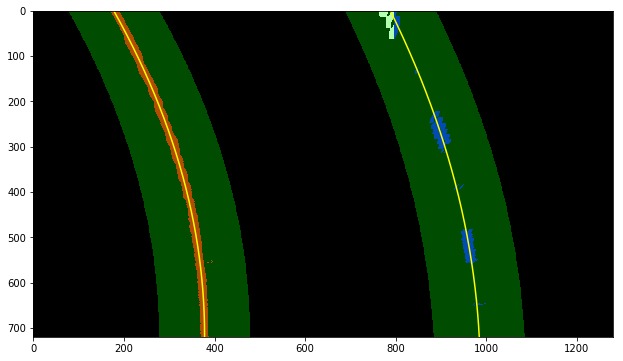

In [15]:
left_x_fit, right_x_fit, y_points, _, _, out_img = find_lane_lines(curve_warp_img, 
                                                                   margin=100,
                                                                   line_windows=True)

plt.figure(figsize=(12,6))
plt.imshow(out_img)
plt.plot(left_x_fit, y_points, color='yellow')
plt.plot(right_x_fit, y_points, color='yellow')

## Computing the radius of curvature and center offset.
The radius of curvature is computed according to the formula and method described in the classroom material. Since we perform the polynomial fit in pixels and whereas the curvature has to be calculated in real world meters, we have to use a pixel to meter transformation and recompute the fit again.
The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center.

In [16]:
def get_radius(x_values_1, x_values_2, num_rows):
    """
    Calculate the radious of curvature in meters given the lane lines and the 
    images number of rows.
    """
    # Conversion  factor form pixel to meters
    PIXEL2METRIC_Y = 30/720   # In the y direction
    PIXEL2METRIC_X = 3.7/700  # In the x direction
    def a_radius(x_values):
        # If rows equal zero, y_val evaluate to None
        if num_rows > 0:
            y_eval = num_rows - 1
        else:
            y_eval = None
        # Fit a polynomial in world space x and y coordinates
        fit_cr = np.polyfit(y_points*PIXEL2METRIC_Y, x_values*PIXEL2METRIC_X, 2)

        return ((1 + (2*fit_cr[0]*y_eval*PIXEL2METRIC_Y + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return (a_radius(x_values_1) + a_radius(x_values_2)) / 2


def get_lane_center(x_values_1, x_values_2, img):
    """
    Calculate the offset distance from the center of the lane.
    """
    # Conversion  factor form pixel to meters
    PIXEL2METRIC_X = 3.7/700 # In the x direction
    
    num_rows = img.shape[0]
    img_width = img.shape[1]
    last_row = num_rows -1
    
    lane_center = (x_values_1[last_row] + x_values_2[last_row]) / 2
    return abs(img_size[0]/2 - lane_center) * PIXEL2METRIC_X

In [17]:
radius = get_radius(left_x_fit, right_x_fit, img.shape[0])
center_offset = get_lane_center(left_x_fit, right_x_fit, img)

print('Radius of curvature: {0:,.1f} mts'.format(radius))
print('Center offset: {0:,.1f} mts'.format(center_offset))

Radius of curvature: 478.4 mts
Center offset: 0.2 mts


### Projecting Measurement onto the Road
In cell below the program perform the following:
* Highlights the lane inner area.
* Perform an inverse perspective transform.
* Blend the processed image with the original image.

In [18]:

def draw_lane(img, camMatrix=camMatrix, distorCoeffs=distorCoeffs, M_inv=None, radious_offet=True):
    """
    Highted the driving lane.
    
    :param img: 
    :param camMatrix: 
    :param distorCoeffs: 
    :param M_inv: 
    :param radious_offet: 
    :return: Image with highlighting the driving lane
    """
    # Create an image to draw the lines on
    color_warp = np.dstack((img, img, img))
    
    # Create a tuple (width, height)
    img_size = (img.shape[1], img.shape[0])
    
    # Undistor the input image
    undist_img = cv2.undistort(img, 
                               camMatrix, 
                               distorCoeffs, 
                               None, 
                               camMatrix)

    # Distortion Correction, Gradient and Color tranfomation to the image
    thresholded_img = get_threshold_img(undist_img)
    
    # Warped image
    warp_img = cv2.warpPerspective(thresholded_img, 
                                   M, 
                                   img_size, 
                                   flags=cv2.INTER_LINEAR)

    # Get the invert matric if
    if M_inv is None:
        src, dst = get_src_dest_points(warp_img)
        M_inv = cv2.getPerspectiveTransform(dst, src)
    
    # Get lane lines information to be drawn
    left_x_fit, right_x_fit, y_points, _, _, out_img = find_lane_lines(warp_img)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_x_fit, y_points]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_x_fit, y_points])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(out_img, M_inv, (img_size)) 
    
    # Combine the result with the original image
    new_img = cv2.addWeighted(img, 1, new_warp, 0.3, 0)
    
    # Add radious and offset information to the image
    if radious_offet is True:
        radious = get_radius(left_x_fit, right_x_fit, img_size[1])
        curve_rad = 'Curve radious: {:,.2f} mts'.format(radious)
        offset = get_lane_center(left_x_fit, right_x_fit, warp_img)
        cent_offset = "Center OFFSET: {:.2f} mts".format(offset) 
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(new_img, curve_rad, (30, 60), font, 0.9, (255,255,255), 2)
        cv2.putText(new_img, cent_offset, (30, 90), font, 0.9, (255,255,255), 2)
    
    return new_img


### - Projecting Lane with Measurements

(-0.5, 1279.5, 719.5, -0.5)

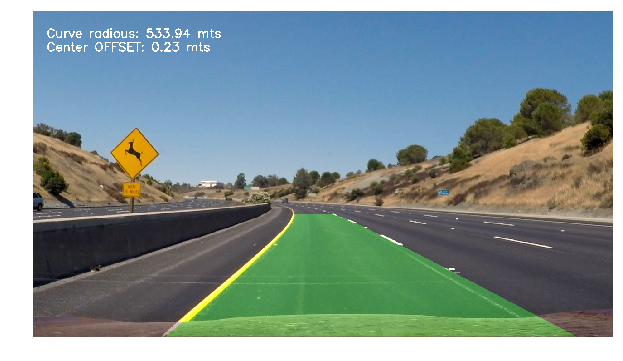

In [19]:
img = mpimg.imread(TESTING_IMG)
result = draw_lane(img, camMatrix, distorCoeffs, M_inv)
plt.figure(figsize=(12,6))
plt.imshow(result)
plt.axis("off")

### - Testing Projection in Multiple Images

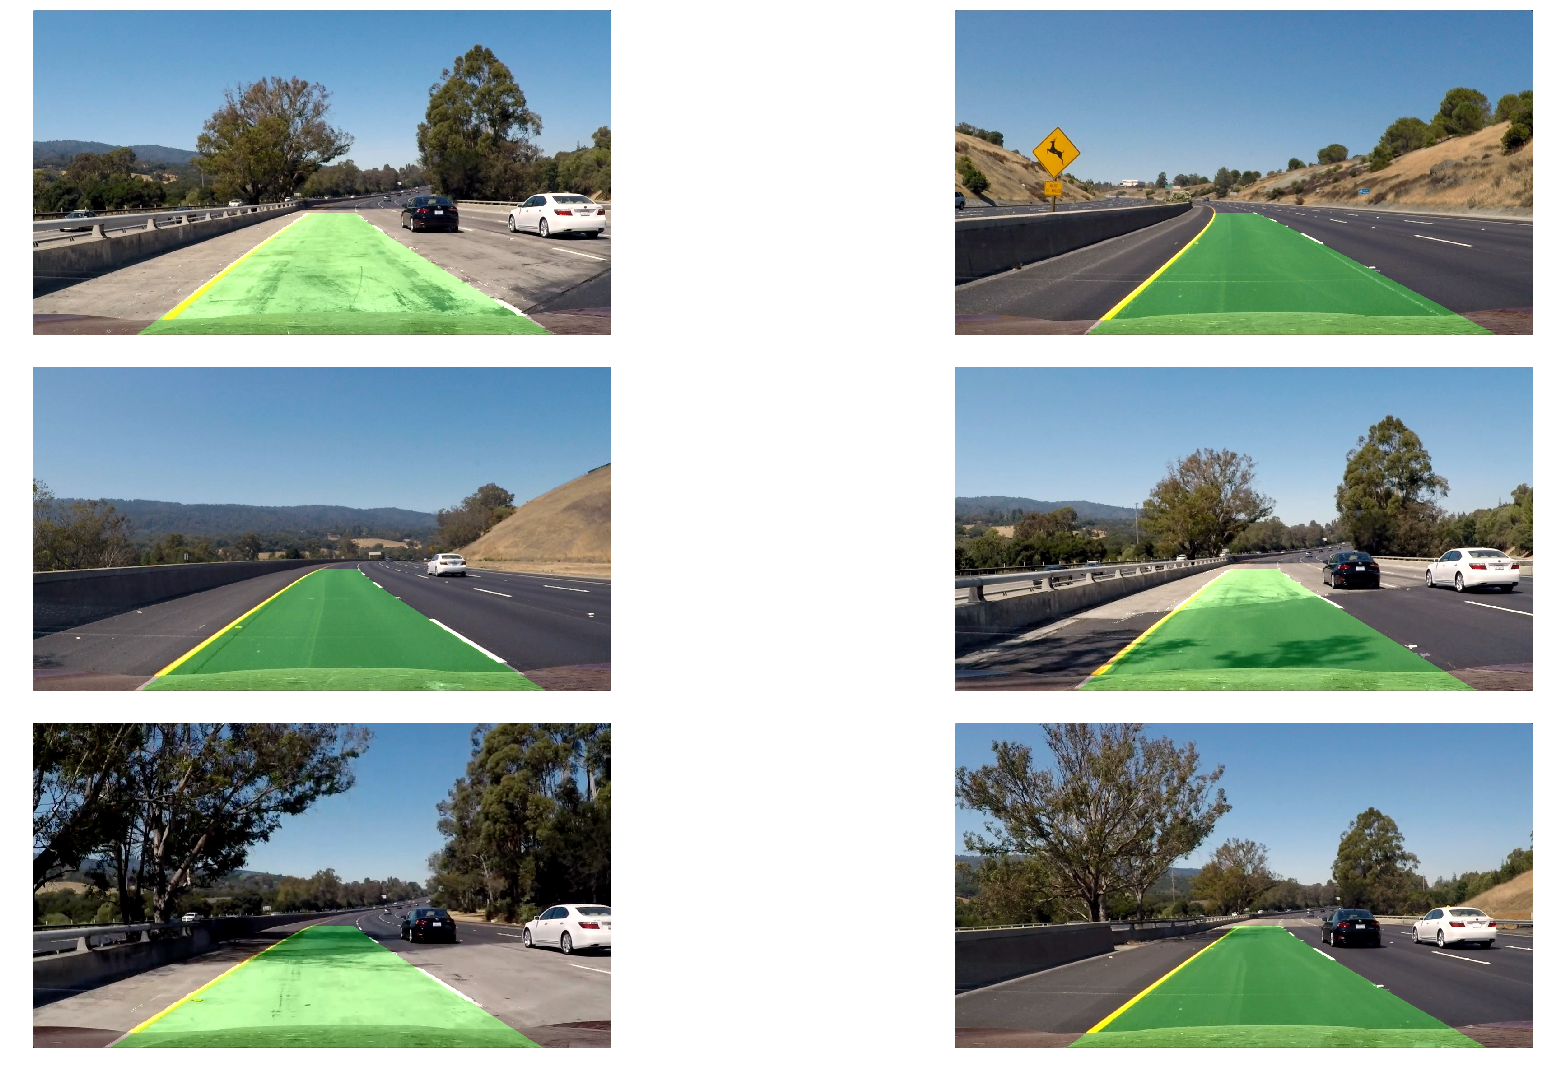

In [20]:
# Run on a test image
import matplotlib.gridspec as gridspec

files_str = 'test_images/test*.jpg'
fnames = glob.glob(files_str)

i = 0
fig = plt.figure(figsize=(30, 15))
gs1 = gridspec.GridSpec(3, 2)

for fname in fnames:
    img = mpimg.imread(fname)
    result = draw_lane(img, camMatrix, distorCoeffs, radious_offet=False)
    axis = plt.subplot(gs1[i])
    axis.axis('off')
    axis.imshow(result)
    i+=1  
    
plt.tight_layout()    
plt.show()   
plt.close('all')    # Closing all images

# Integrating All Concpts

After test all concepts in single image, we are going to integrate all concepts to process a given movie.  In some frames, we will not be able to the detect the lane line correctly, and the program will work it way around to continue processing the following frames.

In [21]:
# Pipeline global variables
left_polyfit = None
right_polyfit = None
left_coord_log = []
right_coord_log = []
avg_lines_separation = 0


#=======================Helper Function==========================

def get_good_inds(non_zeros_y, non_zeros_x, lane_x_min, lane_x_max, y_min, y_max):
    """
    Find the lane coordinate indexes by checking the given coordinates indexes with the
    matching given parameters

    :param non_zeros_y:
    :param non_zeros_x:
    :param lane_x_min: left or right line minimum x value
    :param lane_x_max: left or right line maximum x value
    :param y_min:
    :param y_max:
    :return:  an array with the good coordinates
    """
    good_inds = ((non_zeros_x >= lane_x_min)
               & (non_zeros_x <= lane_x_max)
               & (non_zeros_y >= y_min)
               & (non_zeros_y <= y_max)).nonzero()[0]
    return good_inds

def get_coordinates(non_zeros_x, lane_x_fit, margin):
    """

    :param non_zeros_x:
    :param lane_x_fit: left or right line fit on x values
    :param margin:
    :return: an array with the line coordinates
    """
    coordinates = ((non_zeros_x >= lane_x_fit - margin)
                 & (non_zeros_x <= lane_x_fit + margin)).nonzero()[0]
    return coordinates


def predict_line(non_zeros_x, non_zeros_y, left_coord, right_coord, num_rows):
    """
    Predict the location of the lane lines given non-zeros pixels.

    :param non_zeros_x:
    :param non_zeros_y:
    :param left_coord:
    :param right_coord:
    :param num_rows:
    :return: tuple with left_x_prediction, right_x_prediction
    """
    # Left line coordinates
    left_x = non_zeros_x[left_coord]
    left_y = non_zeros_y[left_coord]
    
    # Right line coordinates
    right_x = non_zeros_x[right_coord]
    right_y = non_zeros_y[right_coord]

    # Return None if not pixels are found
    if left_y.size == 0 or left_x.size == 0 or right_y.size == 0 or right_x.size == 0:
        return None, None

    # Fitting the polynomials
    right_polyfit = np.polyfit(left_y, left_x, 2)
    left_polyfit = np.polyfit(right_y, right_x, 2)

    # Vector with the image indexes
    y_points = np.linspace(0, num_rows - 1, num_rows)

    # Generate the lane lines from the polynomial fit
    left_x_prediction = second_degre_poly(right_polyfit, y_points)
    right_x_prediction = second_degre_poly(left_polyfit, y_points)

    return left_x_prediction, right_x_prediction


def brute_search(warp_img):
    """
    Searches for lane lines in the input image.
    :param warp_img:
    :return: tuple with  left_x_prediction and right_x_prediction
    """""

    non_zeros = warp_img.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]

    num_rows = warp_img.shape[0]

    # Get the left and right X bootom coordinate from the histogram
    _, left_x_base, right_x_base = get_histogram(warp_img)

    num_windows = 10
    window_height = np.int(num_rows / num_windows)
    margin = 60

    min_pixels = 100

    left_coord = []
    right_coord = []

    # Step through the windows one by one
    for window in range(num_windows):
        # Identify window boundaries in x and y (and right and left)
        y_min = num_rows - window_height * (window + 1)
        y_max = num_rows - window_height * window

        left_x_min = left_x_base - margin
        left_x_max = left_x_base + margin
        right_x_min = right_x_base - margin
        right_x_max = right_x_base + margin

        for window in range(num_windows):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (left_x_min, y_min),
                          (left_x_max, y_max), [0, 0, 255], 2)
            cv2.rectangle(out_img, (right_x_min, y_min),
                          (right_x_max, y_max), [0, 0, 255], 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = get_good_inds(non_zeros_y,
                                       non_zeros_x,
                                       left_x_min,
                                       left_x_max,
                                       y_min,
                                       y_max)

        good_right_inds = get_good_inds(non_zeros_y,
                                       non_zeros_x,
                                       right_x_min,
                                       right_x_max,
                                       y_min,
                                       y_max)

        # Appending nonzero pixels in x and y to lines coordinates
        left_coord.append(good_left_inds)
        right_coord.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > min_pixels:
            left_x_base = np.int(np.mean(non_zeros_x[good_left_inds]))

        if len(good_right_inds) > min_pixels:
            right_x_base = np.int(np.mean(non_zeros_x[good_right_inds]))

    # Concatenate the arrays of indices
    left_coord = np.concatenate(left_coord)
    right_coord = np.concatenate(right_coord)

    left_x_prediction, right_x_prediction = predict_line(non_zeros_x,
                                                         non_zeros_y,
                                                         left_coord,
                                                         right_coord,
                                                         num_rows)
    return left_x_prediction, right_x_prediction


def avg_line(previous_lines, new_line):
    """
    Calculate an averaged lane line by averaging over previous good frames.
    :param previous_lines:
    :param new_line:
    :return: Tuple with two lines, previous line and/or a new line
    """

    # Number of image frames to average
    num_frames = 10

    if new_line is None:
        # Line was not detected

        if len(previous_lines) == 0:
            # If there are no previous lines, return None for new_line
            return previous_lines, None
        else:
            # Return the last known line
            return previous_lines, previous_lines[-1]

    elif len(previous_lines) < num_frames:
        # we need at least num_frames frames to average over
        previous_lines.append(new_line)
        return previous_lines, new_line
    else:
        # average over the last number frames
        previous_lines[0:num_frames - 1] = previous_lines[1:]
        previous_lines[num_frames - 1] = new_line
        new_line = np.zeros_like(new_line)
        for i in range(num_frames):
            new_line = np.add(new_line,previous_lines[i])
        new_line = np.divide(new_line, num_frames)
        return previous_lines, new_line


def get_lines_separation(left_line, right_line, running_average):
    """
    Returns running weighted average of simple difference between left and right lines
    :param left_line:
    :param right_line:
    :return:
    """
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average


#======================Pipeline Function===========================

def pipeline(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global left_polyfit
    global right_polyfit
    
    # global variables to store the line coordinates in previous n (=4) frames
    global left_coord_log
    global right_coord_log
    
    # global variable which contains running average of the mean difference between left and right lanes
    global avg_lines_separation
    
    img_shape = img.shape
    img_size = (image_shape[1], image_shape[0])
    
    # get thresholded image
    thresholded = get_threshold_img(img)
    
    # perform a perspective transform
    warp_img = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
    out_img = np.dstack((warp_img, warp_img, warp_img))*255
    
    non_zeros = warp_img.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warp_img.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if right_polyfit is None or left_polyfit is None:
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        brute = True
        left_x_predictions, right_x_predictions = brute_search(warp_img)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        brute = False
        margin = 100

        # Predicting lines
        left_x_predictions = second_degre_poly(left_polyfit, non_zeros_y)
        right_x_predictions = second_degre_poly(right_polyfit, non_zeros_y)
        
        # Obtain line coordinates within the margin 
        left_coordinates = get_coordinates(non_zeros_x, left_x_predictions, margin)
        right_coordinates = get_coordinates(non_zeros_x, right_x_predictions, margin)
        
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, 
                                                                       non_zeros_y, 
                                                                       left_coordinates, 
                                                                       right_coordinates, 
                                                                       num_rows)
    
    if left_x_predictions is None or right_x_predictions is None:
        if not brute:
            left_x_predictions, right_x_predictions = brute_search(warp_img)
            
    bad_lines = False
            
    if left_x_predictions is None or right_x_predictions is None:
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if avg_lines_separation == 0:
            avg_lines_separation = mean_difference
            
                
        # Lines desviation ration used below
        separation_ratio = mean_difference / avg_lines_separation
        
        if separation_ratio < 0.8 or separation_ratio> 1.2:
            bad_lines = True
            if not brute:
                left_x_predictions, right_x_predictions = brute_search(warp_img)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if separation_ratio < 0.8 or separation_ratio> 1.2:
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        right_polyfit = None
        left_polyfit = None
        if len(right_coord_log) == 0 and len(left_coord_log) == 0:
            return img
        else:
            left_x_predictions = right_coord_log[-1]
            right_x_predictions = left_coord_log[-1]
    else:
        right_coord_log, left_x_predictions = avg_line(right_coord_log, left_x_predictions)
        left_coord_log, right_x_predictions = avg_line(left_coord_log, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        avg_lines_separation = 0.9*avg_lines_separation + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    # compute the radius of curvature
    curve_rad = get_radius(left_x_predictions, right_x_predictions, num_rows)
    curve_rad_txt = 'Curve radious: {0:,.2f} mts'.format(curve_rad)
    
    # compute the offset from the center
    center_offset = get_lane_center(left_x_predictions, right_x_predictions, img)
    center_offset_txt = 'Center offset: {0:,.2f} mts'.format(center_offset)
    
    # Hightlighting the lane
    poly_points = np.vstack([left_line_window, right_line_window])
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    # Changing the image perspective back to it original angle
    unwarp_img = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

    # Blending all image information into a sinble output image
    blended_img = cv2.addWeighted(img, 1, unwarp_img, 0.3, 0)
    
    # Attaching the radius and offset info to the output image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(blended_img, curve_rad_txt, (30, 60), font, 1.25, (255,255,255), 2)
    cv2.putText(blended_img, center_offset_txt, (30, 100), font, 1.25, (255,255,255), 2)
    
    return blended_img
 


### Run a test

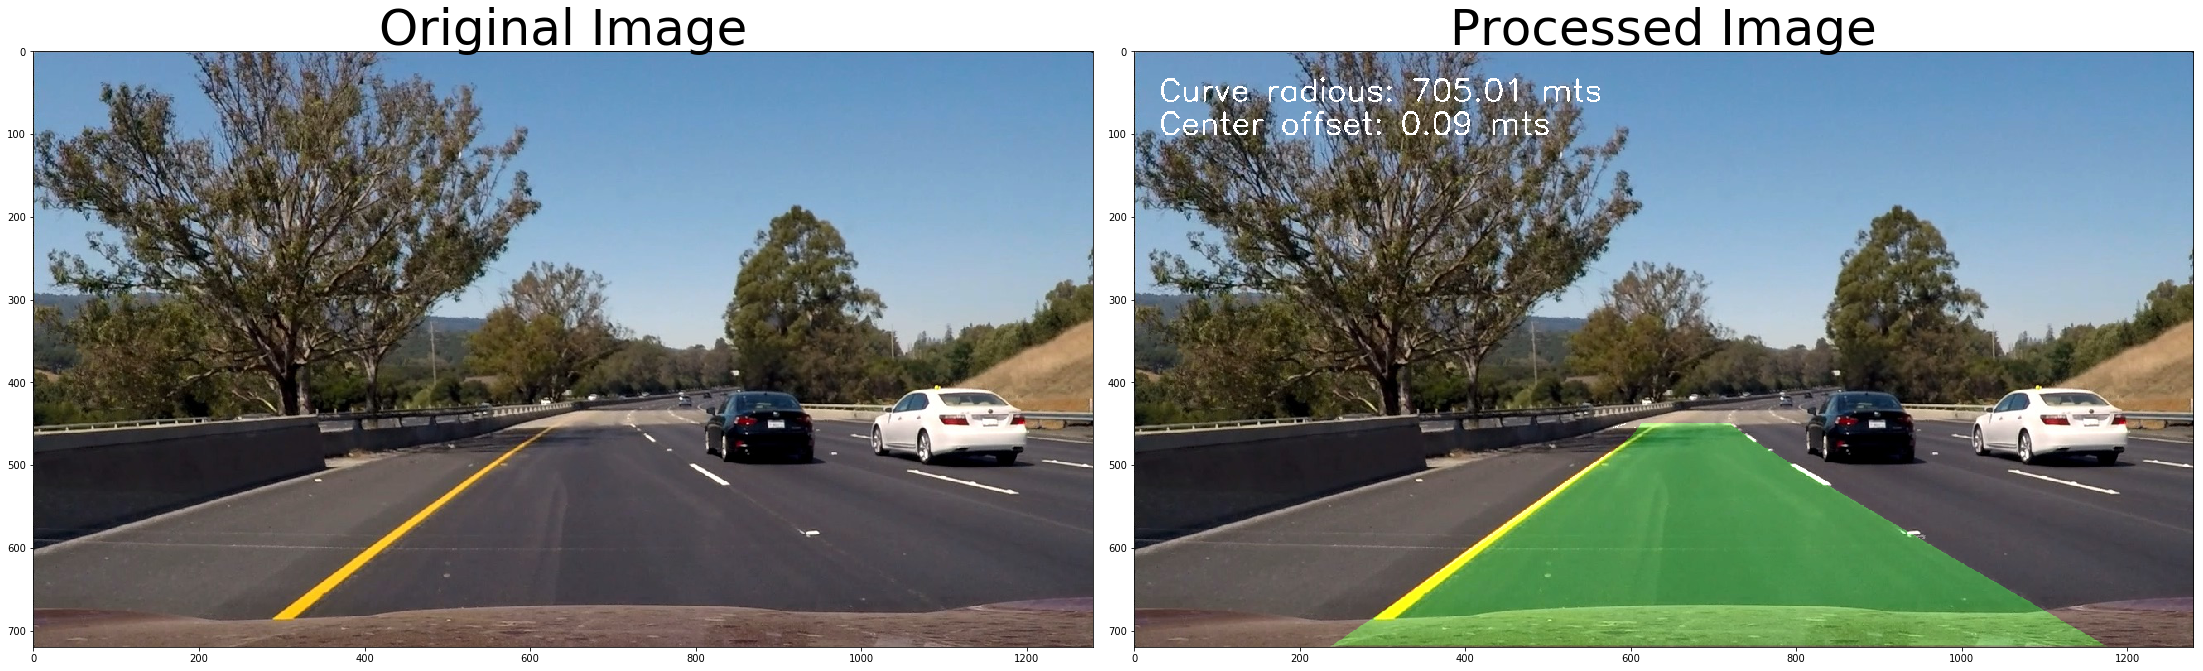

In [22]:
img = mpimg.imread('test_images/test6.jpg')

# Reset global variables
left_polyfit = None
right_polyfit = None
left_coord_log = []
right_coord_log = []
avg_lines_separation = 0

# Applying the pipeline in a sample image
processed = pipeline(img)

display_2_img(img, 'Original Image', processed, 'Processed Image')

In [23]:
from moviepy.editor import VideoFileClip

In [24]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:52<00:00,  4.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 53s
